# Practical Assignment — Random Networks

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest
import random
from itertools import combinations, chain
from functools import partial

**Hints are at the end of the notebook**

### Task 1. Erdos–Renyi model (2 points)
Implement Erdos–Renyi model (random graph) — each pair of `n` nodes are connected with some fixed probability `p`. 

Write a function `random_edges` with parameters `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

In [2]:
'''Do not touch the cell'''
def erdos_renyi_graph(n, p, random_seed=1):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p, random_seed))
    return G

In [3]:
def random_edges(nodes, p, random_seed=1):
    '''Generate a set of random edges'''
    edges = np.array(list(combinations(nodes, 2)))
    gen = np.random.RandomState(random_seed)
    return edges[gen.rand(len(edges)) < p]

In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

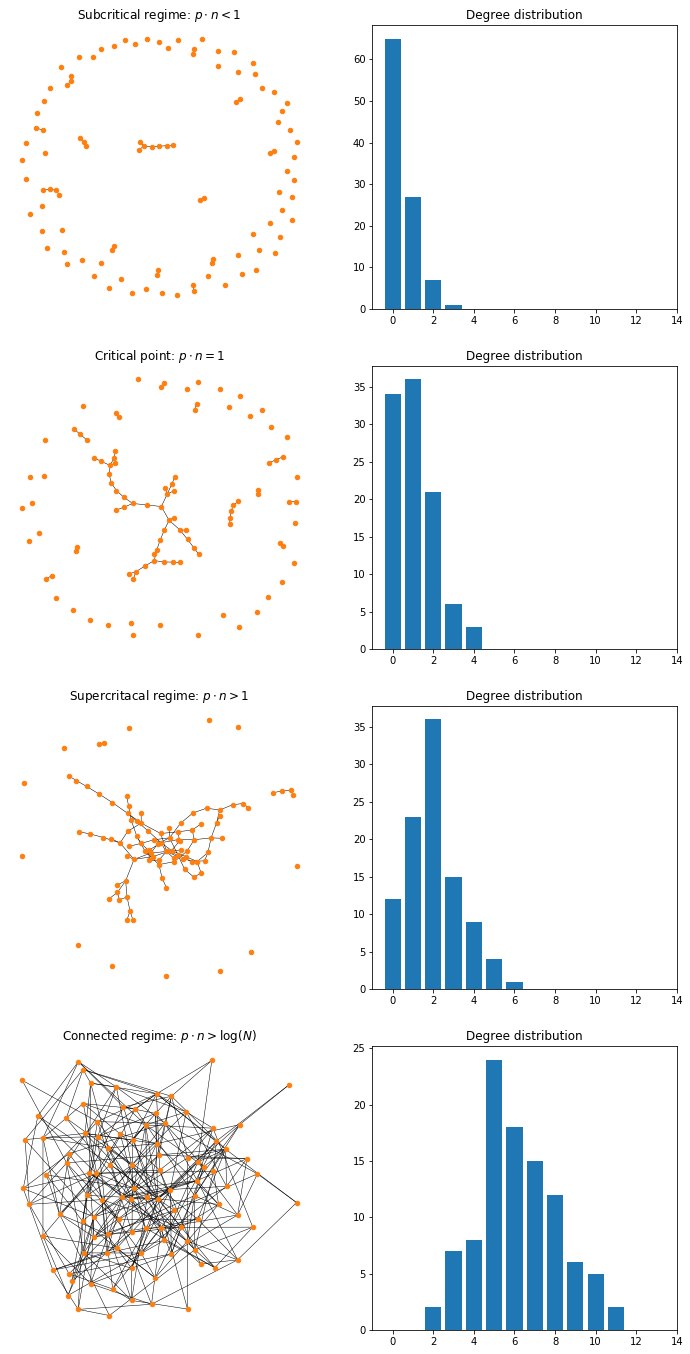

In [5]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n), 
         ('Critical point: $p \cdot n = 1$', n, 1/n), 
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n), 
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p, 2)
    nx.draw_spring(
        G, 
        with_labels=False, 
        node_size=20, 
        width=0.5, 
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Clusterring coefficient (1 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

where $k$ is a node degree, $\langle \cdot \rangle$ is an avarage. Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

In [6]:
def node_degree_clustering(n, p, random_seed=1):
    '''Calculate clustering coefficients'''
    G = erdos_renyi_graph(n, p, random_seed)
    degrees = np.array([i[1] for i in list(G.degree())])
    clustering = np.array(list(nx.clustering(G).values()))
    return degrees, clustering

In [7]:
'''Check the clustering coefficients generation'''
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient

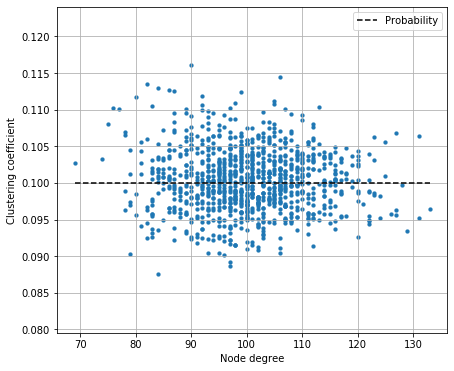

In [8]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.figure(figsize=(7, 6))
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

By the way, let us look at the dependency of a real social network

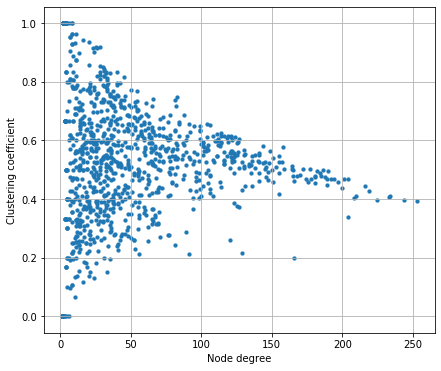

In [9]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_random_networks/sn_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_random_networks/sn_clustering.txt'
)
plt.figure(figsize=(7, 6))
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

### Task 3. Near the critical point (1 points)

Let us see how to change the size of small components (small — not giant), path lengths, clustering coefficient with respect to the probability near the critical point: $p =1/n$.

Write a function `small_comp_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates an Erdos-Renyi random graph for each probability and returns np.array average sizes of small components.

Write a function `path_len` — the same format, returns np.array average path length of a giant component.

Write a function `clustering_coef` — the same format, returns np.array average clustering coefficient

In [10]:
def average_size_small_components(g):
    sizes = np.array(list(map(len, list(nx.connected.connected_components(g)))))
    if len(sizes) == 1:
        return 0.
    return sizes[sizes != sizes.max()].mean()

def small_comp_size(n, probabilities, random_seed=1):
    graphs = [erdos_renyi_graph(n, p, random_seed) for p in probabilities]
    return np.array(list(map(average_size_small_components, graphs)))

In [11]:
def average_path_len(g):
    components = list(nx.connected.connected_components(g))
    sizes = np.array(list(map(len, components)))
    giant_component = g.subgraph(components[np.argmax(sizes)]).copy()
    return nx.average_shortest_path_length(giant_component)

def path_len(n, probabilities, random_seed=1):
    graphs = [erdos_renyi_graph(n, p, random_seed) for p in probabilities]
    return np.array(list(map(average_path_len, graphs)))

In [12]:
def average_clustering_coef(g):
    return np.array(list(nx.clustering(g).values())).mean()

def clustering_coef(n, probabilities, random_seed=1):
    graphs = [erdos_renyi_graph(n, p, random_seed) for p in probabilities]
    return np.array(list(map(average_clustering_coef, graphs)))

In [13]:
'''Check the statistics near the critical point'''
n_cases = [1000, 700]
for n in n_cases:
    p_space = np.linspace(0.5/n, 1.5/n, 20)
    critical = np.argmin(np.abs(1/n - p_space))
    sizes = small_comp_size(n, p_space)
    assert p_space.shape == sizes.shape
    assert 1.5 < max(sizes) < 3
    assert 1 < min(sizes) < 1.5
    assert sizes[0] < sizes[critical]
    assert sizes[19] < sizes[critical]
    
    p_space = np.linspace(0.5/n, 5/n, 20)
    path_lengths = path_len(n, p_space)
    assert path_lengths.shape == p_space.shape
    assert sizes[0] < sizes[critical+2]
    assert sizes[19] < sizes[critical+2]
    
    p_space = np.linspace(0.5/n, 8/n, 20)
    cl_coefs = clustering_coef(n, p_space)
    assert cl_coefs.shape == p_space.shape
    assert sizes[0] < sizes[19]

Let us draw the plots

In [14]:
# n = 1000
# p_space = np.linspace(0.5/n, 1.5/n, 40)
# sizes = small_comp_size(n, p_space)
# plt.plot(p_space*n, sizes)
# plt.plot([1, 1], [min(sizes), max(sizes)], 'k--', label='Critical point')
# plt.xlabel('$p \cdot n$')
# plt.ylabel('Average size of small components')
# plt.legend()
# plt.grid()
# plt.show()

In [15]:
# n = 1000
# p_space = np.linspace(0.5/n, 5/n, 20)
# path_lengths = path_len(n, p_space)
# plt.plot(p_space*n, path_lengths)
# plt.plot([1, 1], [min(path_lengths), max(path_lengths)], 'k--', label='Critical point')
# plt.xlabel('$p \cdot n$')
# plt.ylabel('Average path length')
# plt.legend()
# plt.grid()
# plt.show()

In [16]:
# n = 1000
# p_space = np.linspace(0.5/n, 8/n, 20)
# coefs = clustering_coef(n, p_space)
# plt.plot(p_space*n, coefs)
# plt.plot([1, 1], [min(coefs), max(coefs)], 'k--', label='Critical point')
# plt.xlabel('$p \cdot n$')
# plt.ylabel('Average clustering coefficient')
# plt.legend()
# plt.grid()
# plt.show()

### Task 4. Watts-Strogatz model (2 points)
Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree.

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

In [17]:
'''Do not touch the cell'''
def watts_strogatz_graph(n, k, p, random_seed=1):
    G = ring_lattice(n, k)
    gen = np.random.RandomState(random_seed)
    for node in G.nodes:
        rewire(G, node, k, p, gen)
    return G

In [18]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i + 1, i + halfk + 1):
            v = nodes[j % n]
            yield u, v

def ring_lattice(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k / 2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [19]:
def rewire(G, node, k, p, gen=None):
    '''Rewire edges into the random ones'''
    if gen is None:
        gen = np.random.RandomState()
    size = nx.number_of_nodes(G)
    for i in range(node + 1, int(node + 1 + k / 2)):
        if gen.rand() < p:
            target = gen.choice(size)
            if target != node and not G.has_edge(node, target):
                G.remove_edge(node, i % size)
                G.add_edge(node, target)

In [20]:
'''Compare Watts-Strogatz model with networkx implementation'''
cases = [[50, 8, 0.1], 
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us draw a small-world graph in some steps of the algorithm

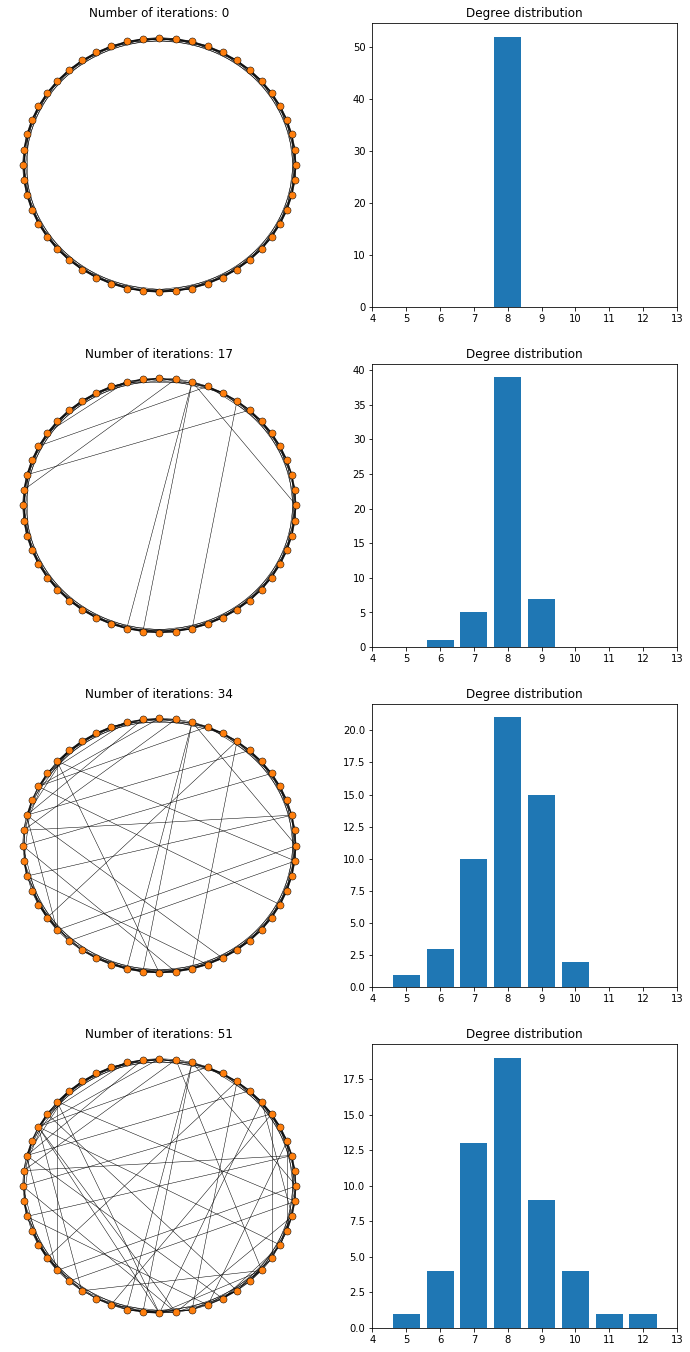

In [21]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
gen = np.random.RandomState(1)
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            with_labels=False, 
            node_size=50, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p, gen)

### Task 5. Average path length in small-worlds (1 point)
Let us check that the average path length decreases during building the small-world model.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

In [22]:
def smallworld_path_len(n, k, p):
    G = ring_lattice(n, k)
    gen = np.random.RandomState()
    lengths = []
    for node in G.nodes:        
        rewire(G, node, k, p, gen)
        lengths.append(nx.average_shortest_path_length(G))
    return np.array(lengths)

In [23]:
'''Check the behaviour of an average path length curve'''
n, k, p = 101, 10, 0.2
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

Let us plot the average path lengths in steps

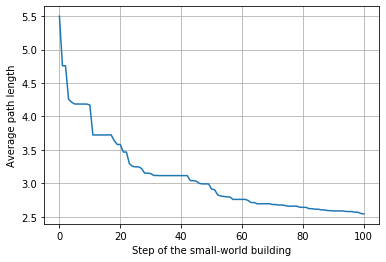

In [24]:
plt.plot(lengths)
plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.show()

### Task 6. Barabasi-Albert model (2 points)
Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

In [25]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    gen = random.Random(random_seed)
    for i in range(1, n - m):
        attach(m + i, G, m, gen)
    return G

In [26]:
def attach(node, G, m, gen=None):
    if gen is None:
        gen = np.random.RandomState()
    nodes = list(chain.from_iterable(G.edges))
    e = nx.number_of_edges(G)
    while nx.number_of_edges(G) < e + m:
        G.add_edge(node, gen.choice(nodes))

In [27]:
'''Compare Barabasi-Albert model with networkx implementation'''
G = nx.star_graph(3)
attach(4, G, 3, random.Random())
assert nx.number_of_edges(G) == 6

cases = [[10, 3], 
         [1000, 3], 
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us see what the growth process looks like

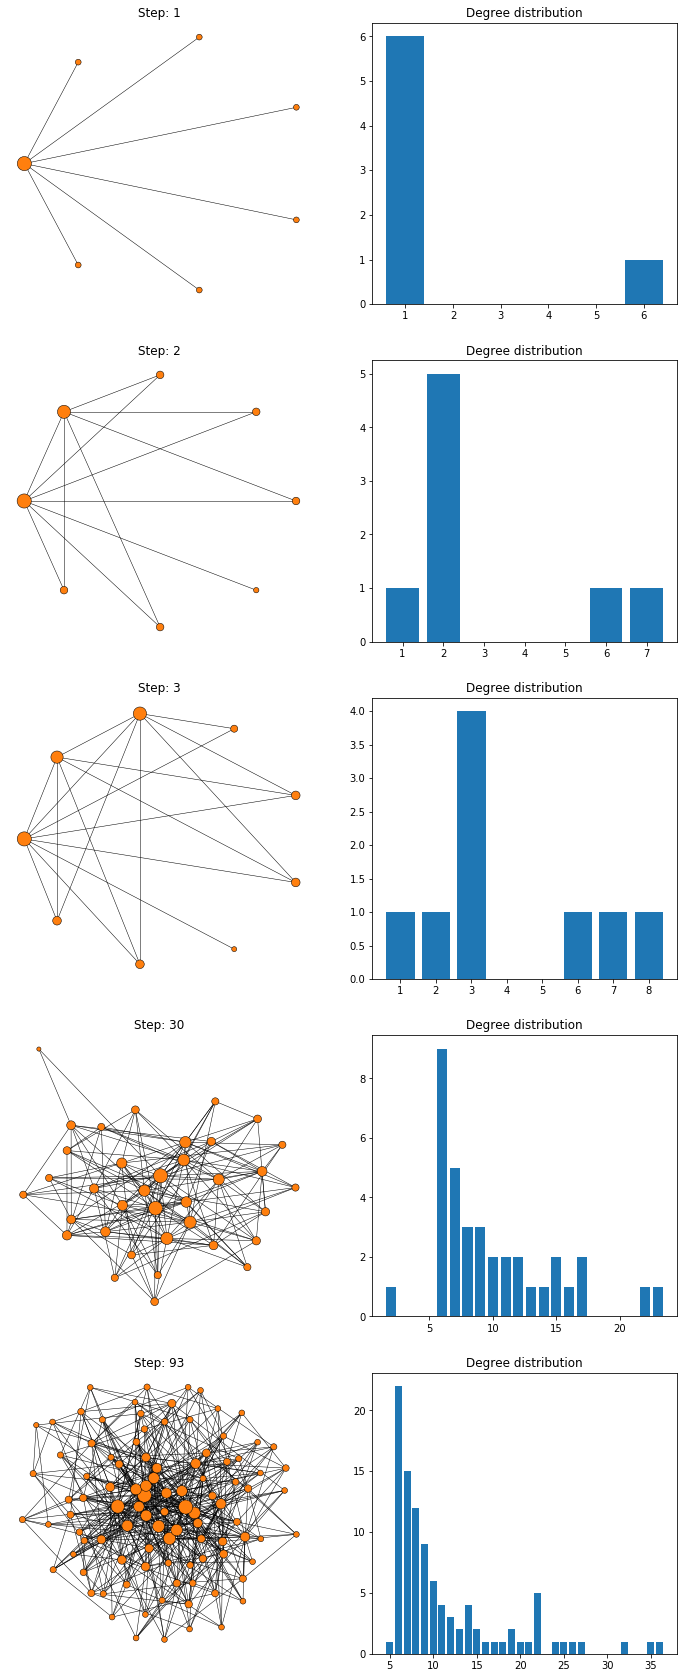

In [28]:
n, m = 100, 6
G = nx.star_graph(m)
gen = random.Random(1)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False, 
            node_size=sizes, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m, gen)

### Task 7. Power law degree distribution (1 point)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$. 

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law.

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

Copy-paste the `ml_power_law_params` and `power_law_cdf` from the power law assignment.

In [29]:
def estimate_power_law(n, m_min, m_max):
    '''Estimate Power law parameters'''
    alphas = []
    k_mins = []
    for m in range(m_min, m_max + 1):
        G = barabasi_albert_graph(n, m)
        alpha, k_min = ml_power_law_params(np.array([d for _, d in G.degree]))
        alphas.append(alpha)
        k_mins.append(k_min)
    return np.array(alphas), np.array(k_mins)

In [30]:
def ml_power_law_params(degree_sequence):
    '''Estimate alpha and x_min via maximum lokelihood'''
    best_alpha, best_x_min, best_ks_statistic = None, None, 1
    x = degree_sequence
    
    for x_min in range(1, int(max(x))):
        x = x[x >= x_min]
        alpha = 1 + len(x) / np.log((x / x_min)).sum()
        if len(x) < 2:
            continue
        ks_statistic = kstest(x, partial(power_law_cdf, alpha=alpha, x_min=x_min)).statistic
        if ks_statistic < best_ks_statistic:
            best_ks_statistic = ks_statistic
            best_x_min = x_min
            best_alpha = alpha
    return best_alpha, best_x_min

In [31]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    '''Calculate cumulative distribution function of Power law'''
    return 1 - (x / x_min) ** (1 - alpha)

In [32]:
'''Check the Power law parameters'''
n, m_min, m_max = 1000, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.min() and alpha.max() < 4
assert k_min[0] < k_min[-1]

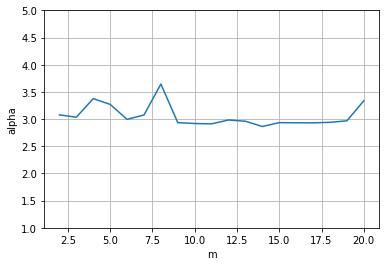

In [33]:
m_space = np.arange(m_min, m_max + 1)
plt.plot(m_space, alpha)
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.show()

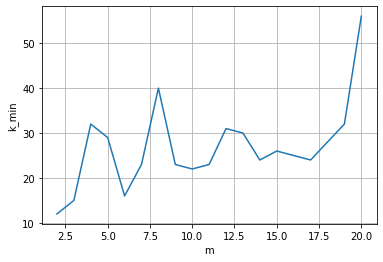

In [34]:
plt.plot(m_space, k_min)
plt.xlabel('m')
plt.ylabel('k_min')
plt.grid()
plt.show()

### Hints
Task 1: 
1. To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf). This algorithm is also implemented in networkx.

Task 4:
1. Why do we only rewire right hand side edges? Because we want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.
![](https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_random_networks/how_to_rewire.png)
2. To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.

Task 6: 
1. Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.